# Assessing the Effects of Edge and Fog Computing on Data Processing Latency

Paulius Tervydis
2024

This example demonstrates how to estimate Edge-Fog networks with different topologies and node interconnections.

Users can define network components and seamlessly interconnect them to create networks of varying sizes and topologies. The code is designed to handle the increasing complexity of networks, allowing users to extend and scale the software to support more complicated scenarios.

## Description of the network

To simulate a network, it is necessary to understand how network nodes are interconnected and how data flows are created and transmitted across the network. For example, in the provided network structure, data flows are initiated by reading data from sensors. The data then undergoes processing, which can be executed by either Edge devices or Fog nodes. The simulation can be utilized to estimate how network performance depends on the distribution of data flows between Edge and Fog processing devices. Additionally, it aids in determining the number of devices needed to meet waiting time requirements, estimating costs, and exploring various scenarios.

<img src="Network%20Diagram.svg" />


The necessary functions and classes that will be used for the network assessment are defined below.

In [125]:
def ssqs(**parameters):
    """This function calculates the parameters of various single-server queueing systems.

    ==============================================================
                Single Server Queueing System (ssqs)
                 +-----------------------------+
      Arrival    |                  Server     |    Output 
                 |    Queue    +--------------+|     
    arrival_rate | ----------+ |              ||      
    ------------>|   | | | | | | service_rate || ------------>
                 | ----------+ |              ||
                 |             +--------------+|   
                 +-----------------------------+

    System notation (A/B/1):
    A - distribution of inter-arrival time 
    B - distribution of service time is determined
    1 - single server
     
    Distribution types: 
    M - exponential, 
    D - determined (fixed), 
    G - general (time variance must be provided))
    ==============================================================

    A queueing system is considered stable when the arrival rate is lower than the service rate.
    If the parameters are incorrect or missing, exceptions will be raised to alert the user.
    Additionally, certain input parameters are optional and can be automatically calculated based
    on the selected system type.

    Parameters
    ----------
    **parameters : (keyword arguments)
    qs : str
        Type of queueing system according Kendall's notations:
        "MM1", "MD1", "MG1", "DM1","DG1","DD1","GM1","GD1". Defaults "MM1".
        Examples of accepted formats: "mm1", "MM1", "m/m/1", "M/M/1"
    ar : float
        Arrival rate. Optional if mean inter-arrival time is given.
    sr : float
        Service rate. Optional if mean service time is given.
    a : float
        Mean inter-arrival time. Optional if arrival rate is given.
    s : float
        Mean service time. Optional if service rate is given.
    va : float
        Variance of inter-arrival time. Must be provided only for "GM1","GD1","GG1" type systems.
    vs : float
        Variance of service time. Must be provided only for "MG1","DG1","GG1" type systems.

    Returns
    -------
    result : dictionary with such keys
    'qs' - queueing system notation
    'ar' - arrival rate
    'sr' - service rate
    'a'  - mean inter-arrival time
    'va' - variance of inter-arrival time
    's'  - mean service time
    'vs' - variance of service time
    'u'  - the utilization of the system
    'l'  - mean number of entities in the system
    'lq' - mean number of entities in the queue
    'w'  - the mean waiting (total time) in system
    'wq' - the mean waiting time in queue

    Example
    -------
    >>> result = ssqs(qs='md1',ar=10,s=0.05)
    >>> print(result)
    >>> {'qs': 'md1', 'ar': 10.0, 'sr': 20.0, 'a': 0.1, 'va': 0.01,
        's': 0.05, 'vs': 0, 'u': 0.5, 'l': 0.75, 'lq': 0.25, 'wq': 0.025, 'w': 0.075}
    """

    # -------------------------------------------------------------------
    qs = None
    a = None
    s = None
    va = None
    vs = None
    ar = None

    if "qs" in parameters:
        qs = parameters.get("qs")

    if qs is None:
        qs = "mm1"

    qs_f = qs.replace("/", "")
    qs_f = qs_f.upper()

    # Arrival parameters -----------------------------------------------
    # arrival rate
    if "ar" in parameters:
        ar = parameters.get("ar")
    # mean inter-arrival time
    if "a" in parameters:
        a = parameters.get("a")
    # variance of inter-arrival times
    if "va" in parameters:
        va = parameters.get("va")

    # Service parameters ---------------------------------------------
    # service rate
    if "sr" in parameters:
        sr = parameters.get("sr")
    # mean service time
    if "s" in parameters:
        s = parameters.get("s")
        if s is not None:
            sr = 1/s
    # variance of service times
    if "vs" in parameters:
        vs = parameters.get("vs")

    # Verification ---------------------------------------------------
    if ar == 0:
        a = float('inf')
    else:
        a = 1 / ar
    if sr == 0:
        s = float('inf')
    else:
        s = 1 / sr
    if qs_f[0] == "G" and va is None:
        raise Exception("Missing parameters. 'va' value is not provided")
    if qs_f[1] == "G" and vs is None:
        raise Exception("Missing parameters. 'vs' value is not provided")
    if qs_f[0] == "M":
        va = a ** 2
    if qs_f[1] == "M":
        vs = s ** 2
    if qs_f[0] == "D":
        va = 0
    if qs_f[1] == "D":
        vs = 0
    if qs_f[2] != "1":
        raise Exception("Incompatible system notation")
    if a is None and ar is not None:
        a = 1 / ar
    if a is None and ar is None:
        raise Exception("Missing parameters. 'ar' or 'a' values are not provided")
    if s is None and sr is not None:
        s = 1 / sr
    if s is None and sr is None:
        raise Exception("Missing parameters. 'sr' or 's' values are not provided")

    if s < 0 or a < 0:
        raise Exception("Negative parameters. Ensure that 'a' and 's' > 0")
    if qs_f[0] == "G" or qs_f[1] == "G":
        if vs < 0 or va < 0:
            raise Exception("Negative parameters. Ensure that 'va' and 'vs' > 0")
    if s >= a:
        raise Exception("Unstable system, because Arrival rate > Service rate. Ensure that: 's' < 'a' or 'ar' < 'sr'")

    # Parameter calculation -----------------------------------------
    # The arrival rate
    ar = 1 / a
    # The service rate
    sr = 1 / s
    # The utilization of the system
    u = ar / sr
    # The mean waiting time in queue:
    if qs_f == "MM1":
        wq = (u * s)/(1 - u)
    elif qs_f == "MD1":
        wq = (u * s)/(2*(1 - u))
    else:
        # The actual mean waiting time in queue is obtained by Marchall’s approximation
        wq = (u * s) / (2 * (1 - u)) * ((va + vs) /
                                        (s ** 2)) * ((s ** 2 + vs) / (a ** 2 + vs))
    # The mean total time in system
    w = wq + s
    # The mean number of entities in the system
    l = ar * w
    # The mean number of entities in the queue
    lq = ar * wq
    result = {"qs": qs,
              "ar": round(ar,14),
              "sr": round(sr,14),
              "a" : round(a,14),
              "va": round(va,14),
              "s" : round(s,14),
              "vs": round(vs,14),
              "u" : round(u,14),
              "l" : round(l,14),
              "lq": round(lq,14),
              "wq": round(wq,14),
              "w" : round(w,14)}
    return result
# ==============================================================


class Node:
    """All the network node classes are inherited from the Node class.

    Parameters
    ----------
    id : str
        Text string to describe a network node.
    input_rate : float
        Arrival rate.
    service_rate : float
        Service rate.
    output_rate : float
        Output rate.
    input : list
        List of nodes that are connected to this node. Data flow is arriving from the nodes to this node's input.
    output : list
        List of nodes that this node is connected to. Data flow from this node's output goes to the inputs of the nodes in the list.
    time_in_system : float
        Sum of time spent in the node's queue and service (processing) time.
    total_time : float
        Cumulative time in the network (from the node that starts data flow to this node inclusive).
    profit : float
        Cumulative profit of the network link (from the node that starts data flow to this node inclusive).
    """

    def __init__(self,id,rate):
        """Constructor"""
        self.id = id
        self.input_rate = 0
        self.service_rate = None
        self.output_rate = None
        self.input = []
        self.output = []
        self.time_in_system = 0
        self.utilization = 0
        self.total_time = 0
        self.profit = 0

    def connect_to(self, node, ratio=1):
        """Function used to connect this node to another. If this node is connected to several
        another nodes, then the output flow ratio can be defined."""
        node.set_input(self, ratio)
        self.output.append(node)

    def set_input(self, node, ratio=1):
        """Function sets the input and the data flow ratio to a node."""
        self.input.append(node)
        self.input_rate += node.output_rate*ratio
        parameters = ssqs(qs="md1",ar=self.input_rate,sr=self.service_rate)
        self.time_in_system = parameters['w']
        self.utilization = parameters['u']

        dt = 1/self.input_rate+self.time_in_system
        self.output_rate = 1/dt

    def __str__(self):
        """This function creates a string output with node parameters if print(node) is used"""
        attrs = vars(self)
        vars_str = ""
        for item in attrs:
            if item == "output":
                for o in self.output:
                    vars_str += "%s: %s, " % (item, o.id)
            elif item == "input":
                for i in self.input:
                    vars_str += "%s: %s, " % (item, i.id)
            else:
                vars_str += "%s: %s, " % (item,attrs[item])
        return vars_str

    def get_info(self, total_time=0, total_profit=0, links=""):
        """This function is used recursively to form the output prompt with a network link
        details starting from the node that originates data flow to the terminal node."""
        total_time += self.time_in_system
        total_profit += self.profit
        for i,output in enumerate(self.output):
            if i==0:
                links += self.id+" --> "
            output.get_info(total_time,total_profit,links)
        if len(self.output) == 0:
            if total_profit!=0:
                print(links + self.id+", Total time: %f"%(total_time*3600) + ", Total profit: %f"%total_profit)
            else:
                print(links + self.id+", Total time: %f"%(total_time*3600))
        

class Sensor(Node):
    """Class that defines data flow originating network node"""
    def __init__(self,id,input_rate):
        Node.__init__(self,id,input_rate)
        self.input_rate = input_rate
        self.output_rate = input_rate
        self.service_rate = input_rate
        self.total_time = 0
        self.profit = 0

class DataChannel(Node):
    """Class to define a data network channel."""
    def __init__(self,id,service_rate):
        Node.__init__(self,id,service_rate)
        self.service_rate = service_rate

class Balancer(Node):
    """Class to define load balancer. It is used to define data flow ratios."""
    def __init__(self,id,rate=0):
        Node.__init__(self,id,rate)
        self.service_rate = rate
    def set_input(self, node,ratio=1):
        self.input.append(node)
        self.input_rate += node.output_rate*ratio
        self.time_in_system = 0
        dt = 1/self.input_rate+self.time_in_system
        self.output_rate = 1/dt

class Database(Node):
    """Class to define a database. In the given example it is used as data flow termination node."""
    def __init__(self,id,service_rate):
        Node.__init__(self,id,service_rate)
        self.service_rate = service_rate

class EdgeDevice(Node):
    """Class to define an Edge device.
    Additional parameters to estimate Edge devices working battery time, cost and revenue are added."""
    def __init__(self,id,service_rate,battery_perf_index=0,cost=0,revenue_index=0):
        Node.__init__(self,id,service_rate)
        self.service_rate = service_rate
        self.battery_perf_index = battery_perf_index
        self.battery_time = None
        self.cost = cost
        self.revenue = 0
        self.revenue_index = revenue_index
        self.profit = 0
    def set_input(self, node, ratio=1):
        self.input.append(node)
        self.input_rate += node.output_rate*ratio
        parameters = ssqs(qs="md1",ar=self.input_rate,sr=self.service_rate)
        self.time_in_system = parameters['w']
        self.utilization = parameters['u']
        self.battery_time = self.battery_perf_index/(self.utilization*self.service_rate)
        dt = 1/self.input_rate+self.time_in_system
        self.output_rate = 1/dt
        self.revenue = self.input_rate*self.revenue_index
        self.profit = self.revenue - self.cost

class FogNode(Node):
    """Class to define a Fog node.
    Additional parameters to estimate cost and revenue are added."""
    def __init__(self,id,service_rate,cost=0,revenue_index=0):
        Node.__init__(self,id,service_rate)
        self.service_rate = service_rate
        self.cost = cost
        self.revenue = 0
        self.revenue_index = revenue_index
        self.profit = 0
    def set_input(self, node, ratio=1):
        self.input.append(node)
        self.input_rate += node.output_rate*ratio
        parameters = ssqs(qs="md1",ar=self.input_rate,sr=self.service_rate)
        self.time_in_system = parameters['w']
        self.utilization = parameters['u']
        dt = 1/self.input_rate+self.time_in_system
        self.output_rate = 1/dt
        self.revenue = self.input_rate*self.revenue_index
        self.profit = self.revenue - self.cost

class CloudServer(Node):
    """Class to define a Cloud server.
    Additional parameters to estimate cost and revenue are added."""
    def __init__(self,id,service_rate,cost=0,revenue_index=0):
        Node.__init__(self,id,service_rate)
        self.service_rate = service_rate
        self.cost = cost
        self.revenue = 0
        self.revenue_index = revenue_index
        self.profit = 0
    def set_input(self, node, ratio=1):
        self.input.append(node)
        self.input_rate += node.output_rate*ratio
        parameters = ssqs(qs="md1",ar=self.input_rate,sr=self.service_rate)
        self.time_in_system = parameters['w']
        self.utilization = parameters['u']
        dt = 1/self.input_rate+self.time_in_system
        self.output_rate = 1/dt
        self.revenue = self.input_rate*self.revenue_index
        self.profit = self.revenue - self.cost

## Initial parameters

The parameters of data flow generation, processing and distribution are defined in following code block.

In [126]:
sensor_data_polling_rate = 30 # req/h (sensor polling rate = rate of data processing requests)
sensor_data_length = 8000*8 # bits
sensor_network_data_rate = 1_000_000 # bits/s
sensor_network_service_rate = 3600*sensor_network_data_rate/sensor_data_length # req/h
revenue_per_processed_data = 0.1 # Eur

edge_network_data_rate = 100_000_000 # bits/s
edge_network_service_rate = 3600*edge_network_data_rate/sensor_data_length # req/h
edge_device_data_processing_time = 0.15 # s
edge_device_battery_perf_index = 200 # number of data processing cycles to discharge a full battery (used to estimate how many hours Edge device may work on battery)
edge_device_service_rate = 3600*1/edge_device_data_processing_time # req/h
edge_device_cost = 0.5 # Eur/h

fog_computing_network_data_rate = 1_000_000_000 # bits/s
fog_computing_network_service_rate = 3600*fog_computing_network_data_rate/sensor_data_length # req/h
fog_node_processing_time = 0.1 # s
fog_node_service_rate = 3600*1/fog_node_processing_time # req/h
fog_node_cost = 0.15 # Eur/h

processed_data_length = 200*8 # bits
cloud_storage_network_data_rate = 1_000_000_000 # bits/s
cloud_database_data_write_rate = 200_000_000*8 # bits/s
cloud_storage_network_service_rate = 3600*cloud_storage_network_data_rate/processed_data_length # req/h
cloud_database_service_rate = 3600*cloud_database_data_write_rate/processed_data_length # req/h

edge_load_ratio = 0.2
fog_load_ratio = 1 - edge_load_ratio

## Network creation example


All network node classes inherit from the general Node class, incorporating specific changes that pertain to individual network node features.

The subsequent code block includes an example demonstrating how to create various network nodes, interconnect them, simulate data flow, and review the resulting parameters.

If the exception error occurs (Exception: Unstable system, because Arrival rate > Service rate. Ensure that: 's' < 'a' or 'ar' < 'sr'), it indicates that the intensity of the data flow from the sensors exceeds the data processing rate of Edge devices or Fog nodes. In such a case, it is recommended to either decrease the number of sensors or the data polling rate, or alternatively, increase the number of data processing Edge devices and Fog nodes.

In [127]:
# Creates three Sensors with given id strings and data polling rate
sensor1 = Sensor("Sensor 1",sensor_data_polling_rate)
sensor2 = Sensor("Sensor 2",sensor_data_polling_rate)
sensor3 = Sensor("Sensor 3",sensor_data_polling_rate)

# Creates three Edge devices for sensor data processing with given parameters
edge_device1 = EdgeDevice("Edge 1",edge_device_service_rate,edge_device_battery_perf_index,edge_device_cost,revenue_per_processed_data)
edge_device2 = EdgeDevice("Edge 2",edge_device_service_rate,edge_device_battery_perf_index,edge_device_cost,revenue_per_processed_data)
edge_device3 = EdgeDevice("Edge 3",edge_device_service_rate,edge_device_battery_perf_index,edge_device_cost,revenue_per_processed_data)

# Creates three Fog nodes for sensor data processing with given parameters
fog_node1 = FogNode("Fog Node 1",fog_node_service_rate,fog_node_cost,revenue_per_processed_data)
fog_node2 = FogNode("Fog Node 2",fog_node_service_rate,fog_node_cost,revenue_per_processed_data)
fog_node3 = FogNode("Fog Node 3",fog_node_service_rate,fog_node_cost,revenue_per_processed_data)

# Creates Edge gateway that performs load balancing between Edge and Fog networks
balancer = Balancer("Edge Gateway")

# Creates Database that stores processed data results
database = Database("Database",cloud_database_service_rate)

# Creates Sensor, Edge, Fog Computing and Cloud Storage network data channels
sensor_network = DataChannel("Sensor Network",sensor_network_service_rate)
edge_network = DataChannel("Edge Network",edge_network_service_rate)
fog_network = DataChannel("FogComputing Network",fog_computing_network_service_rate)
cloud_storage_network = DataChannel("Cloud Storage Network",cloud_storage_network_service_rate)

# Connects sensors to the Sensor network
sensor1.connect_to(sensor_network)
sensor2.connect_to(sensor_network)
sensor3.connect_to(sensor_network)

# Connects Sensor network to the Edge gateway (load balancer)
sensor_network.connect_to(balancer)

# Connects Edge gateway (load balancer) to the Edge and Fog networks with given load distribution ratios
balancer.connect_to(edge_network,edge_load_ratio)
balancer.connect_to(fog_network,fog_load_ratio)

# Connects Edge network to the Edge devices with given load distribution ratios
# (ratios may be different, but their sum must be equal to 1)
edge_network.connect_to(edge_device1,ratio=2/9)
edge_network.connect_to(edge_device2,ratio=3/9)
edge_network.connect_to(edge_device3,ratio=4/9)

# Connects Fog network to the Fog nodes with given load distribution ratios
fog_network.connect_to(fog_node1,ratio=2/9)
fog_network.connect_to(fog_node2,ratio=4/9)
fog_network.connect_to(fog_node3,ratio=3/9)

# Connects all data processing nodes to the Cloud storage network
edge_device1.connect_to(cloud_storage_network)
edge_device2.connect_to(cloud_storage_network)
edge_device3.connect_to(cloud_storage_network)
fog_node1.connect_to(cloud_storage_network)
fog_node2.connect_to(cloud_storage_network)
fog_node3.connect_to(cloud_storage_network)

# Connects Cloud storage network to the Database
cloud_storage_network.connect_to(database)



## Simulation results

In [128]:
# The get_info() function can be used to review how data is transferred from Sensors to the Database (last node)
print("sensor1.get_info() results:")
sensor1.get_info()

# To review all the network node parameters the print(node) function can be used, for example
print("\nprint(edge_device1) results:")
print(edge_device1)

# To obtain value of particular parameter node.parameter syntax is used, for example
print("\nprint(edge_device1.battery_time) results:")
print(edge_device1.battery_time)

sensor1.get_info() results:
Sensor 1 --> Sensor Network --> Edge Gateway --> Edge Network --> Edge 1 --> Cloud Storage Network --> Database, Total time: 0.214706, Total profit: -0.100641
Sensor 1 --> Sensor Network --> Edge Gateway --> Edge Network --> Edge 2 --> Cloud Storage Network --> Database, Total time: 0.214713, Total profit: 0.099039
Sensor 1 --> Sensor Network --> Edge Gateway --> Edge Network --> Edge 3 --> Cloud Storage Network --> Database, Total time: 0.214719, Total profit: 0.298718
Sensor 1 --> Sensor Network --> Edge Gateway --> FogComputing Network --> Fog Node 1 --> Cloud Storage Network --> Database, Total time: 0.164140, Total profit: 1.447440
Sensor 1 --> Sensor Network --> Edge Gateway --> FogComputing Network --> Fog Node 2 --> Cloud Storage Network --> Database, Total time: 0.164162, Total profit: 3.044880
Sensor 1 --> Sensor Network --> Edge Gateway --> FogComputing Network --> Fog Node 3 --> Cloud Storage Network --> Database, Total time: 0.164151, Total prof

## Data processing latency estimation

The subsequent code block illustrates how to modify the given example to generate a desired number of Sensors, Edge devices, and Fog nodes. In this particular case, the load from Edge Network to Edge devices is evenly distributed, and the load from Fog Processing Network to Fog nodes is also evenly distributed. That's why the resulting parameters are identical for all Edge devices and the same for Fog nodes.

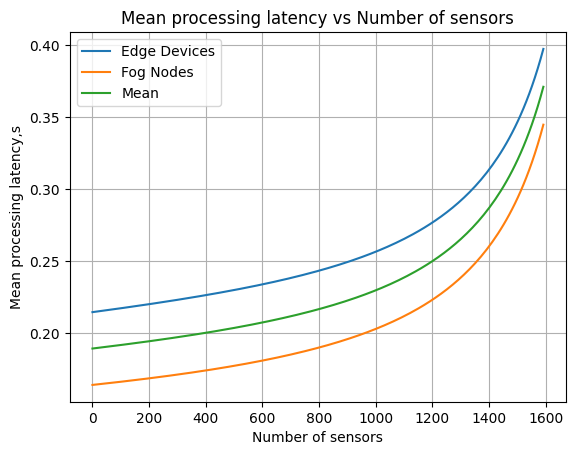

Sensor Network --> Edge Gateway --> Edge Network --> Edge 1 --> Cloud Storage Network --> Database, Total time: 0.397611, Total profit: 112.348410
Sensor Network --> Edge Gateway --> Edge Network --> Edge 2 --> Cloud Storage Network --> Database, Total time: 0.397611, Total profit: 112.348410
Sensor Network --> Edge Gateway --> Edge Network --> Edge 3 --> Cloud Storage Network --> Database, Total time: 0.397611, Total profit: 112.348410
Sensor Network --> Edge Gateway --> Edge Network --> Edge 4 --> Cloud Storage Network --> Database, Total time: 0.397611, Total profit: 112.348410
Sensor Network --> Edge Gateway --> Edge Network --> Edge 5 --> Cloud Storage Network --> Database, Total time: 0.397611, Total profit: 112.348410
Sensor Network --> Edge Gateway --> Fog Computing Network --> Fog Node 1 --> Cloud Storage Network --> Database, Total time: 0.344954, Total profit: 112.800436
Sensor Network --> Edge Gateway --> Fog Computing Network --> Fog Node 2 --> Cloud Storage Network --> Da

In [129]:
import matplotlib.pyplot as plt
# Number of Sensors, Edge devices and Fog nodes servers is defined:
mean_processing_latency_edge = []
mean_processing_latency_fog = []
mean_processing_latency = []


sensors_no_list = range(1,1601,10)
for sensors_no in sensors_no_list:

    edge_devices_no = 5
    fog_nodes_no = 5

    # Load distribution between Edge network and Fog network is defined:
    edge_load_ratio = 0.5
    fog_load_ratio = 1 - edge_load_ratio

    # Lists of sensors, edge_devices and cloud_servers are created:
    sensors = []
    for s_no in range(1,sensors_no+1):
        sensors.append(Sensor("Sensor %d"%s_no,sensor_data_polling_rate))

    edge_devices = []
    for e_no in range(1,edge_devices_no+1):
        edge_devices.append(EdgeDevice("Edge %d"%e_no,edge_device_service_rate,edge_device_battery_perf_index,edge_device_cost,revenue_per_processed_data))
    fog_nodes = []
    for f_no in range(1,fog_nodes_no+1):
        fog_nodes.append(FogNode("Fog Node %d"%f_no,fog_node_service_rate,fog_node_cost,revenue_per_processed_data))

    # Everything is interconnected according the simulated network architecture
    sensor_network = DataChannel("Sensor Network",sensor_network_service_rate)
    edge_network = DataChannel("Edge Network",edge_network_service_rate)
    fog_network = DataChannel("Fog Computing Network",fog_computing_network_service_rate)

    balancer = Balancer("Edge Gateway")

    cloud_storage_network = DataChannel("Cloud Storage Network",cloud_storage_network_service_rate)
    database = Database("Database",cloud_database_service_rate)

    for sensor in sensors:
        sensor.connect_to(sensor_network)

    sensor_network.connect_to(balancer)
    balancer.connect_to(edge_network,edge_load_ratio)
    balancer.connect_to(fog_network,fog_load_ratio)

    for edge_device in edge_devices:
        edge_network.connect_to(edge_device,1/edge_devices_no) # 1/edge_devices_no - equal distribution ratio

    for fog_node in fog_nodes:
        fog_network.connect_to(fog_node,1/fog_nodes_no)

    for edge_device in edge_devices:
        edge_device.connect_to(cloud_storage_network)

    for fog_node in fog_nodes:
        fog_node.connect_to(cloud_storage_network)

    cloud_storage_network.connect_to(database)

    mte = sensors[0].time_in_system+sensor_network.time_in_system+balancer.time_in_system+edge_network.time_in_system+edge_devices[0].time_in_system#+cloud_storage_network.time_in_system#+database.time_in_system
    mtf = sensors[0].time_in_system+sensor_network.time_in_system+balancer.time_in_system+fog_network.time_in_system+fog_nodes[0].time_in_system#+cloud_storage_network.time_in_system#+database.time_in_system
  
    mean_processing_latency_edge.append(mte*3600)
    mean_processing_latency_fog.append(mtf*3600)
    mean_processing_latency.append((mte*edge_load_ratio+mtf*fog_load_ratio)*3600)


plt.figure()

plt.plot(sensors_no_list,mean_processing_latency_edge, label='Edge Devices')
plt.plot(sensors_no_list,mean_processing_latency_fog, label='Fog Nodes')
plt.plot(sensors_no_list,mean_processing_latency, label='Mean')
plt.xlabel("Number of sensors")
plt.ylabel("Mean data processing latency,s")
plt.title("Mean data processing latency vs Number of sensors")
plt.grid()
plt.legend()
plt.draw()
plt.show()

sensor_network.get_info()